In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation: FashionMNIST dataset with normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # converts [0,255] to [0,1]
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 1. Fully Connected Autoencoder (FC-AE)

class FCAutoencoder(nn.Module):
    def __init__(self):
        super(FCAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [batch, 1, 28, 28]
        x = x.view(x.size(0), -1)  # flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded, encoded


# 2. Convolutional Autoencoder (CNN-AE)

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# 3. Sparse Autoencoder (using L1 penalty)

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded, encoded

# 4. Recurrent Autoencoder (RNN-AE)

class RNNAutoencoder(nn.Module):
    def __init__(self, hidden_size=128, seq_len=28, input_size=28):
        super(RNNAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder_lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = x.squeeze(1)
        # Encode with LSTM; we only use the final hidden state
        _, (h, _) = self.encoder_lstm(x)  # h: [1, batch, hidden_size]
        h = h.squeeze(0)  # [batch, hidden_size]
        # Repeat the latent vector for each time step
        repeated = h.unsqueeze(1).repeat(1, self.seq_len, 1)  # [batch, 28, hidden_size]
        # Decode
        decoded_seq, _ = self.decoder_lstm(repeated)
        decoded = self.fc(decoded_seq)  # [batch, 28, 28]
        # Apply sigmoid and reshape to [batch, 1, 28, 28]
        decoded = torch.sigmoid(decoded)
        decoded = decoded.unsqueeze(1)
        return decoded

# 5. Variational Autoencoder (VAE)

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.sigmoid(self.fc_decode(z))
        return h3

    def forward(self, x):
        # x: [batch, 1, 28, 28]
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        x_recon = x_recon.view(x.size(0), 1, 28, 28)
        return x_recon, mu, logvar



In [ ]:
# Training Functions for Each Model

num_epochs = 50

def train_model(model, loader, optimizer, criterion, device, extra_loss_fn=None):
    model.train()
    running_loss = 0.0
    for data, _ in loader:
        data = data.to(device)
        optimizer.zero_grad()
        # For models that return two outputs (like FC and Sparse AE)
        outputs = model(data)
        if isinstance(outputs, tuple):
            recon = outputs[0]
            encoded = outputs[1] if len(outputs) > 1 else None
        else:
            recon = outputs
            encoded = None
        loss = criterion(recon, data)
        # For Sparse AE: add L1 regularization on the encoded activations
        if extra_loss_fn is not None and encoded is not None:
            loss = loss + extra_loss_fn(encoded)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(loader.dataset)

def evaluate_model(model, loader, criterion, device, extra_loss_fn=None):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            outputs = model(data)
            if isinstance(outputs, tuple):
                recon = outputs[0]
                encoded = outputs[1] if len(outputs) > 1 else None
            else:
                recon = outputs
                encoded = None
            loss = criterion(recon, data)
            if extra_loss_fn is not None and encoded is not None:
                loss = loss + extra_loss_fn(encoded)
            running_loss += loss.item() * data.size(0)
    return running_loss / len(loader.dataset)

# Training loop for VAE requires a special loss function
def loss_function_vae(recon_x, x, mu, logvar):
    # Flatten images
    x = x.view(x.size(0), -1)
    recon_x = recon_x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
# 1. Train Fully Connected Autoencoder

fc_model = FCAutoencoder().to(device)
optimizer_fc = optim.Adam(fc_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

print("Training Fully Connected Autoencoder...")
for epoch in range(num_epochs):
    train_loss = train_model(fc_model, train_loader, optimizer_fc, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

Training Fully Connected Autoencoder...
Epoch [1/50], Loss: 0.3783
Epoch [2/50], Loss: 0.3079
Epoch [3/50], Loss: 0.2917
Epoch [4/50], Loss: 0.2835
Epoch [5/50], Loss: 0.2791
Epoch [6/50], Loss: 0.2763
Epoch [7/50], Loss: 0.2743
Epoch [8/50], Loss: 0.2727
Epoch [9/50], Loss: 0.2715
Epoch [10/50], Loss: 0.2705
Epoch [11/50], Loss: 0.2697
Epoch [12/50], Loss: 0.2690
Epoch [13/50], Loss: 0.2684
Epoch [14/50], Loss: 0.2679
Epoch [15/50], Loss: 0.2674
Epoch [16/50], Loss: 0.2670
Epoch [17/50], Loss: 0.2666
Epoch [18/50], Loss: 0.2663
Epoch [19/50], Loss: 0.2661
Epoch [20/50], Loss: 0.2659
Epoch [21/50], Loss: 0.2657
Epoch [22/50], Loss: 0.2655
Epoch [23/50], Loss: 0.2653
Epoch [24/50], Loss: 0.2652
Epoch [25/50], Loss: 0.2651
Epoch [26/50], Loss: 0.2650
Epoch [27/50], Loss: 0.2649
Epoch [28/50], Loss: 0.2648
Epoch [29/50], Loss: 0.2647
Epoch [30/50], Loss: 0.2647
Epoch [31/50], Loss: 0.2646
Epoch [32/50], Loss: 0.2645
Epoch [33/50], Loss: 0.2644
Epoch [34/50], Loss: 0.2645
Epoch [35/50], Lo

In [ ]:
# 2. Train Convolutional Autoencoder

cnn_model = CNNAutoencoder().to(device)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

print("\nTraining Convolutional Autoencoder...")
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer_cnn.zero_grad()
        recon = cnn_model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer_cnn.step()
        running_loss += loss.item() * data.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")



Training Convolutional Autoencoder...
Epoch [1/50], Loss: 0.3293
Epoch [2/50], Loss: 0.2790
Epoch [3/50], Loss: 0.2737
Epoch [4/50], Loss: 0.2707
Epoch [5/50], Loss: 0.2687
Epoch [6/50], Loss: 0.2673
Epoch [7/50], Loss: 0.2661
Epoch [8/50], Loss: 0.2651
Epoch [9/50], Loss: 0.2641
Epoch [10/50], Loss: 0.2633
Epoch [11/50], Loss: 0.2626
Epoch [12/50], Loss: 0.2619
Epoch [13/50], Loss: 0.2614
Epoch [14/50], Loss: 0.2609
Epoch [15/50], Loss: 0.2604
Epoch [16/50], Loss: 0.2599
Epoch [17/50], Loss: 0.2595
Epoch [18/50], Loss: 0.2591
Epoch [19/50], Loss: 0.2588
Epoch [20/50], Loss: 0.2584
Epoch [21/50], Loss: 0.2582
Epoch [22/50], Loss: 0.2579
Epoch [23/50], Loss: 0.2577
Epoch [24/50], Loss: 0.2575
Epoch [25/50], Loss: 0.2573
Epoch [26/50], Loss: 0.2571
Epoch [27/50], Loss: 0.2569
Epoch [28/50], Loss: 0.2568
Epoch [29/50], Loss: 0.2566
Epoch [30/50], Loss: 0.2564
Epoch [31/50], Loss: 0.2563
Epoch [32/50], Loss: 0.2562
Epoch [33/50], Loss: 0.2560
Epoch [34/50], Loss: 0.2559
Epoch [35/50], Los

In [ ]:
# 3. Train Sparse Autoencoder (with L1 penalty)

sparse_model = SparseAutoencoder().to(device)
optimizer_sparse = optim.Adam(sparse_model.parameters(), lr=0.001)
l1_weight = 1e-4  # regularization strength

def l1_penalty(encoded):
    return l1_weight * torch.mean(torch.abs(encoded))

print("\nTraining Sparse Autoencoder...")
for epoch in range(num_epochs):
    train_loss = train_model(sparse_model, train_loader, optimizer_sparse, criterion, device, extra_loss_fn=l1_penalty)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")



Training Sparse Autoencoder...
Epoch [1/50], Loss: 0.3808
Epoch [2/50], Loss: 0.3103
Epoch [3/50], Loss: 0.2930
Epoch [4/50], Loss: 0.2842
Epoch [5/50], Loss: 0.2797
Epoch [6/50], Loss: 0.2770
Epoch [7/50], Loss: 0.2750
Epoch [8/50], Loss: 0.2735
Epoch [9/50], Loss: 0.2724
Epoch [10/50], Loss: 0.2713
Epoch [11/50], Loss: 0.2704
Epoch [12/50], Loss: 0.2698
Epoch [13/50], Loss: 0.2692
Epoch [14/50], Loss: 0.2688
Epoch [15/50], Loss: 0.2684
Epoch [16/50], Loss: 0.2680
Epoch [17/50], Loss: 0.2677
Epoch [18/50], Loss: 0.2675
Epoch [19/50], Loss: 0.2672
Epoch [20/50], Loss: 0.2670
Epoch [21/50], Loss: 0.2668
Epoch [22/50], Loss: 0.2666
Epoch [23/50], Loss: 0.2665
Epoch [24/50], Loss: 0.2664
Epoch [25/50], Loss: 0.2662
Epoch [26/50], Loss: 0.2662
Epoch [27/50], Loss: 0.2661
Epoch [28/50], Loss: 0.2660
Epoch [29/50], Loss: 0.2658
Epoch [30/50], Loss: 0.2657
Epoch [31/50], Loss: 0.2656
Epoch [32/50], Loss: 0.2655
Epoch [33/50], Loss: 0.2654
Epoch [34/50], Loss: 0.2654
Epoch [35/50], Loss: 0.26

In [ ]:
# 4. Train Recurrent Autoencoder (RNN-AE)

rnn_model = RNNAutoencoder().to(device)
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001)

print("\nTraining Recurrent Autoencoder...")
for epoch in range(num_epochs):
    rnn_model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer_rnn.zero_grad()
        recon = rnn_model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer_rnn.step()
        running_loss += loss.item() * data.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")



Training Recurrent Autoencoder...
Epoch [1/50], Loss: 0.4509
Epoch [2/50], Loss: 0.3584
Epoch [3/50], Loss: 0.3372
Epoch [4/50], Loss: 0.3228
Epoch [5/50], Loss: 0.3142
Epoch [6/50], Loss: 0.3090
Epoch [7/50], Loss: 0.3051
Epoch [8/50], Loss: 0.3009
Epoch [9/50], Loss: 0.2988
Epoch [10/50], Loss: 0.2965
Epoch [11/50], Loss: 0.2943
Epoch [12/50], Loss: 0.2930
Epoch [13/50], Loss: 0.2900
Epoch [14/50], Loss: 0.2891
Epoch [15/50], Loss: 0.2873
Epoch [16/50], Loss: 0.2861
Epoch [17/50], Loss: 0.2851
Epoch [18/50], Loss: 0.2839
Epoch [19/50], Loss: 0.2824
Epoch [20/50], Loss: 0.2824
Epoch [21/50], Loss: 0.2802
Epoch [22/50], Loss: 0.2803
Epoch [23/50], Loss: 0.2798
Epoch [24/50], Loss: 0.2784
Epoch [25/50], Loss: 0.2780
Epoch [26/50], Loss: 0.2773
Epoch [27/50], Loss: 0.2769
Epoch [28/50], Loss: 0.2762
Epoch [29/50], Loss: 0.2759
Epoch [30/50], Loss: 0.2750
Epoch [31/50], Loss: 0.2743
Epoch [32/50], Loss: 0.2743
Epoch [33/50], Loss: 0.2737
Epoch [34/50], Loss: 0.2733
Epoch [35/50], Loss: 0

In [ ]:
# 5. Train Variational Autoencoder (VAE)

vae_model = VAE(latent_dim=2).to(device)
optimizer_vae = optim.Adam(vae_model.parameters(), lr=0.001)

print("\nTraining Variational Autoencoder...")
vae_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer_vae.zero_grad()
        recon, mu, logvar = vae_model(data)
        loss = loss_function_vae(recon, data, mu, logvar)
        loss.backward()
        optimizer_vae.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")



Training Variational Autoencoder...
Epoch [1/50], Loss: 517.9469
Epoch [2/50], Loss: 411.7731
Epoch [3/50], Loss: 376.0749
Epoch [4/50], Loss: 344.1278
Epoch [5/50], Loss: 330.5324
Epoch [6/50], Loss: 324.1010
Epoch [7/50], Loss: 319.6928
Epoch [8/50], Loss: 316.5633
Epoch [9/50], Loss: 313.7584
Epoch [10/50], Loss: 311.6252
Epoch [11/50], Loss: 309.9167
Epoch [12/50], Loss: 308.4353
Epoch [13/50], Loss: 307.2347
Epoch [14/50], Loss: 306.1952
Epoch [15/50], Loss: 305.2491
Epoch [16/50], Loss: 304.5440
Epoch [17/50], Loss: 303.8156
Epoch [18/50], Loss: 303.1402
Epoch [19/50], Loss: 302.6240
Epoch [20/50], Loss: 302.1980
Epoch [21/50], Loss: 301.7688
Epoch [22/50], Loss: 301.3899
Epoch [23/50], Loss: 301.0634
Epoch [24/50], Loss: 300.7734
Epoch [25/50], Loss: 300.4966
Epoch [26/50], Loss: 300.2126
Epoch [27/50], Loss: 299.9921
Epoch [28/50], Loss: 299.8062
Epoch [29/50], Loss: 299.5748
Epoch [30/50], Loss: 299.5009
Epoch [31/50], Loss: 299.3087
Epoch [32/50], Loss: 299.0673
Epoch [33/50

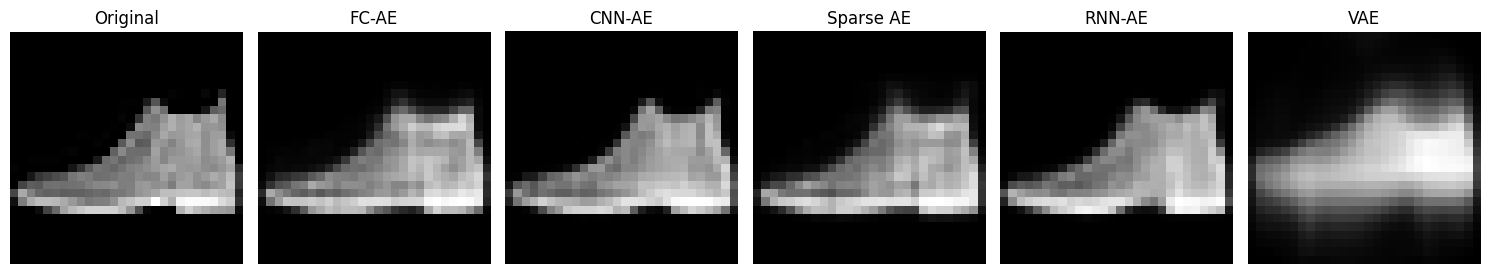

In [ ]:
# Evaluate and Visualize a Sample Reconstruction

import numpy as np

# Get a single batch from test set
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)

# Get reconstructions from each autoencoder
with torch.no_grad():
    # FC-AE reconstruction
    recon_fc, _ = fc_model(images)
    # CNN-AE reconstruction
    recon_cnn = cnn_model(images)
    # Sparse AE reconstruction
    recon_sparse, _ = sparse_model(images)
    # RNN-AE reconstruction
    recon_rnn = rnn_model(images)
    # VAE reconstruction
    recon_vae, _, _ = vae_model(images)

# Choose the first image from the batch
orig_img = images[0].cpu().squeeze().numpy()
recon_fc_img = recon_fc[0].cpu().squeeze().numpy()
recon_cnn_img = recon_cnn[0].cpu().squeeze().numpy()
recon_sparse_img = recon_sparse[0].cpu().squeeze().numpy()
recon_rnn_img = recon_rnn[0].cpu().squeeze().numpy()
recon_vae_img = recon_vae[0].cpu().squeeze().numpy()

# Plot the original and reconstructed images
fig, axs = plt.subplots(1, 6, figsize=(15,3))
axs[0].imshow(orig_img, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(recon_fc_img, cmap='gray')
axs[1].set_title('FC-AE')
axs[2].imshow(recon_cnn_img, cmap='gray')
axs[2].set_title('CNN-AE')
axs[3].imshow(recon_sparse_img, cmap='gray')
axs[3].set_title('Sparse AE')
axs[4].imshow(recon_rnn_img, cmap='gray')
axs[4].set_title('RNN-AE')
axs[5].imshow(recon_vae_img, cmap='gray')
axs[5].set_title('VAE')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()